In [1]:
import df_filter_nvida
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
from nltk.tokenize import word_tokenize
import re
from unidecode import unidecode
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter

from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

In [2]:
stop_words = set(stopwords.words('english'))

In [3]:
news_articles_data = pd.read_csv("data/us_equities_news_dataset.csv")

In [4]:
# Sample keywords related to NVIDIA and associated companies
nvidia_keywords = [
    'NVDA', 'NVIDIA']

'''

More keywords can be added to the list to improve the filtering process. But adding all those increases the document number significantly making processing slower and creating memory issues that are unsolvable by my mere laptop. 

nvidia_keywords = [
    'NVDA', 'NVIDIA', 'NIO', 'UBER', 'AMZN', 'AMAZON', 'TESLA', 'AI', 'GPU', 'GRAPHICS',
    'CHIP', 'SEMICONDUCTOR', 'AUTONOMOUS', 'DRIVING', 'DEEP LEARNING', 'MACHINE LEARNING'
]

'''

# Compile a regex pattern from the keywords list
nvidia_pattern = '|'.join(nvidia_keywords)  # Combines the keywords into a regex pattern

# Filter articles where the content or ticker column contains any of the keywords
df_news = news_articles_data[
    news_articles_data['content'].str.contains(nvidia_pattern, case=False, na=False)
]

In [5]:
df_news = df_news.drop_duplicates(subset='content', keep='first').reset_index(drop=True)
df_news

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221539,NIO,A Central Bank War Just Started And Its Good F...,opinion,ECB Effects\nThe move in the euro was huge fa...,2019-03-07,Michael Kramer,https://www.investing.com/analysis/a-central-b...,200395687
1,221547,NIO,6 Stocks To Watch Nivida Could Be Falling,opinion,6 Stocks To Watch March 6 Trading Session\nSt...,2019-03-06,Michael Kramer,https://www.investing.com/analysis/6-stocks-to...,200394931
2,221572,NIO,Stocks Dow Drops Nearly 400 Points as Apple ...,news,Investing com A rout in Apple and Facebook ...,2018-11-19,Investing.com,https://www.investing.com/news/stock-market-ne...,1694042
3,221593,UBER,The Zacks Analyst Blog Highlights Advanced Mi...,opinion,For Immediate ReleaseChicago IL January 13 ...,2020-01-12,Zacks Investment Research,https://www.investing.com/analysis/the-zacks-a...,200498277
4,221597,UBER,The Best Of CES 2020 Revised,opinion,With 4 500 companies bringing their innovation...,2020-01-16,Zacks Investment Research,https://www.investing.com/analysis/the-best-of...,200499164
...,...,...,...,...,...,...,...,...,...
3436,442657,AMD,Here s Why Nvidia NVDA Stock Is Gaining Today,opinion,Shares of Nvidia NASDAQ NVDA are up nearly...,2016-09-27,Zacks Investment Research,https://www.investing.com/analysis/here's-why-...,200155860
3437,442682,AMD,4 Stocks To Watch Today ATW CWEI MXL SLCA,opinion,It was a pretty good start to the week on Mond...,2016-05-17,Harry Boxer,"https://www.investing.com/analysis/atw,-cwei,-...",200130262
3438,442705,AMD,Here s What The Buy Side Expects From AMD Thur...,opinion,Advanced Micro Devices Inc NYSE AMD is set ...,2014-04-17,Estimize,https://www.investing.com/analysis/here’s-what...,209915
3439,442984,T,Zacks com Featured Highlights AT T Nu Skin E...,opinion,For Immediate Release\n\nChicago IL July 22...,2016-07-21,Zacks Investment Research,https://www.investing.com/analysis/zacks.com-f...,200143537


## Preprocessing takes places in the following steps:
- Lowercasing the text
- Removing non-alphabetic characters
- Removing accents
- Tokenization
- Removing stopwords
- Removing top and bottom n% of words

In [6]:
def preprocess_texts(texts, n=0):
    processed_texts = []
    for text in texts:
        # lowercasing, keep text only, remove accents, tokenization
        tokens = [word for word in word_tokenize(re.sub(r'[^a-zA-Z\s]', '', unidecode(text.lower())))]
        # stopword removal
        tokens = [token for token in tokens if token not in stopwords.words('english')]
        processed_texts.append(tokens)
        # remove top-n% and bottom-n% words
    if n > 0:
        word_freq = Counter([word for sentence in processed_texts for word in sentence])
        top_n = set([word for word, _ in word_freq.most_common(int(n/100*len(word_freq)))])
        bottom_n = set([word for word, _ in word_freq.most_common()[:-int(n/100*len(word_freq))-1:-1]])
        processed_texts = [[word for word in sentence if word not in top_n and word not in bottom_n] for sentence in
    processed_texts]
        
    return processed_texts

In [7]:
# Preprocess the filtered news content
processed_content = preprocess_texts(df_news['content'].tolist())

# Show the first few processed texts
processed_content[1:5]

[['stocks',
  'watch',
  'march',
  'trading',
  'session',
  'stocks',
  'stocks',
  'went',
  'pretty',
  'much',
  'nowhere',
  'march',
  'p',
  'finishing',
  'day',
  'bps',
  'modestly',
  'surprised',
  'stocks',
  'get',
  'boost',
  'strong',
  'services',
  'pmi',
  'data',
  'came',
  'versus',
  'estimates',
  'one',
  'highest',
  'reading',
  'time',
  'let',
  'us',
  'forget',
  'services',
  'industry',
  'us',
  'far',
  'outweighs',
  'manufacturing',
  'sector',
  'nice',
  'obsess',
  'weak',
  'manufacturing',
  'pmi',
  'sounds',
  'dire',
  'creates',
  'headlines',
  'doom',
  'let',
  'stop',
  'call',
  'day',
  'biotech',
  'xbi',
  'biotechi',
  'stocks',
  'plunged',
  'news',
  'fda',
  'commish',
  'dr',
  'scott',
  'gottlieb',
  'resigning',
  'reason',
  'decline',
  'market',
  'fears',
  'unknown',
  'knowing',
  'next',
  'commissioner',
  'unknown',
  'sell',
  'first',
  'ask',
  'questions',
  'later',
  'see',
  'chart',
  'day',
  'going',
  

## Filter out the most common words using this function. We can use it to remove common words found within our corpus in order to improve the quality of the topics generated by the LDA model.

In [8]:
def filter_word_from_corpus(data, words):
    # Ensure words is a list, even if a single string is passed
    if isinstance(words, str):
        words = [words]
    # Filter words from data
        filtered_data = [[token for token in row if token not in words] for row in data]
        
    return filtered_data

In [14]:
# Create a dictionary from the processed content
dictionary = corpora.Dictionary(processed_content)

# Convert the list of documents (corpus) into Document Term Matrix using the dictionary prepared above
doc_term_matrix = [dictionary.doc2bow(doc) for doc in processed_content]

First Iteration of LDA with 3 topics. The coherence score is low which indicates that the topics are not coherent. This means that we probably need to iterate between different topic numbers.

In [9]:
# Train the LDA model
num_topics = 3
lda_model = LdaModel(
    doc_term_matrix,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,  # More passes can improve the model
    random_state=17
)

# Print the topics
for topic in lda_model.print_topics():
    print(topic)

# Get coherence score
coherence_model = CoherenceModel(model=lda_model, texts=processed_content, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

(0, '0.021*"zacks" + 0.017*"earnings" + 0.012*"company" + 0.012*"year" + 0.011*"stocks" + 0.010*"growth" + 0.008*"rank" + 0.008*"nasdaq" + 0.007*"stock" + 0.007*"quarter"')
(1, '0.016*"year" + 0.012*"company" + 0.011*"quarter" + 0.010*"million" + 0.010*"nvidia" + 0.009*"nasdaq" + 0.008*"billion" + 0.007*"zacks" + 0.007*"revenues" + 0.006*"technology"')
(2, '0.013*"nasdaq" + 0.007*"nyse" + 0.006*"market" + 0.006*"u" + 0.006*"week" + 0.005*"trade" + 0.005*"stock" + 0.005*"stocks" + 0.005*"nvidia" + 0.005*"shares"')
Coherence Score: 0.4203


In this visualisation we can observe that some words like Company and Market are common in all topics. This is because they are common in the corpus and are not filtered out. We can filter out these words and re-run the LDA model to see if the topics improve.

In [10]:
# Visualization with pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.display(vis)

In [16]:
def compute_coherence_values(dictionary, corpus, texts, passes, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, random_state=17)
        model_list.append(lda_model)
        coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())

    return model_list, coherence_values


# We can now run the function to compute the coherence values for different number of topics. We can then plot the coherence values to determine the optimal number of topics.

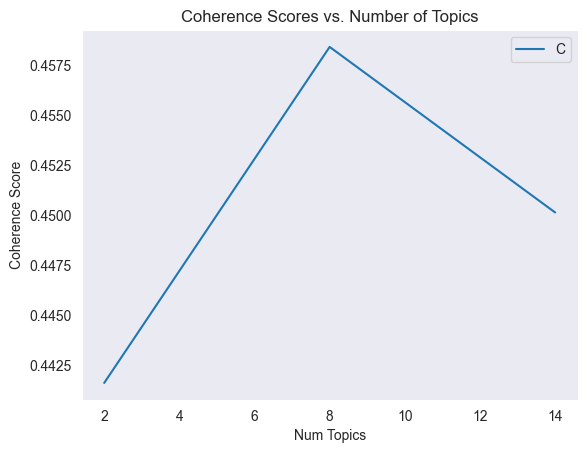

In [17]:
model_list, coherence_values = compute_coherence_values(
    dictionary=dictionary,
    corpus=doc_term_matrix,
    texts=processed_content,
    passes=10,
    start=2,
    limit=20,
    step=6
)

limit = 20
start = 2
step = 6
x = range(start, limit, step)

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence Values"), loc='best')
plt.title("Coherence Scores vs. Number of Topics")
plt.grid()
plt.show()

# We can see that 8 is probably the best number of topics for now since it has the highest coherence score. We can now train the LDA model with 8 topics and visualize the topics.

In [18]:
# Train the LDA model
num_topics = 8
lda_model = LdaModel(
    doc_term_matrix,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,  # More passes can improve the model
    random_state=17
)

# Print the topics
for topic in lda_model.print_topics():
    print(topic)

# Get coherence score
coherence_model = CoherenceModel(model=lda_model, texts=processed_content, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f'Coherence Score: {coherence_score:.4f}')

(0, '0.048*"percent" + 0.008*"new" + 0.007*"said" + 0.007*"p" + 0.006*"shares" + 0.005*"billion" + 0.005*"n" + 0.005*"reuters" + 0.005*"nasdaq" + 0.005*"stocks"')
(1, '0.022*"etf" + 0.019*"fund" + 0.015*"nasdaq" + 0.012*"semiconductor" + 0.010*"technology" + 0.009*"companies" + 0.009*"etfs" + 0.008*"inc" + 0.008*"top" + 0.007*"index"')
(2, '0.015*"nasdaq" + 0.015*"u" + 0.010*"china" + 0.010*"nyse" + 0.009*"trade" + 0.006*"year" + 0.006*"said" + 0.006*"shares" + 0.006*"stocks" + 0.005*"earnings"')
(3, '0.024*"year" + 0.021*"quarter" + 0.021*"zacks" + 0.018*"company" + 0.014*"earnings" + 0.013*"million" + 0.012*"revenues" + 0.010*"growth" + 0.009*"rank" + 0.009*"billion"')
(4, '0.012*"nvidia" + 0.009*"company" + 0.009*"nasdaq" + 0.008*"intel" + 0.007*"amd" + 0.007*"technology" + 0.007*"market" + 0.006*"new" + 0.005*"also" + 0.005*"data"')
(5, '0.053*"nasdaq" + 0.032*"inc" + 0.029*"nvidia" + 0.025*"nyse" + 0.022*"traded" + 0.019*"shares" + 0.016*"trade" + 0.014*"rose" + 0.013*"stock" + 0.